In [1]:
# numerics
import numpy as np
import math as m
import scipy
from scipy.fftpack import fft,ifft,fftshift,fft2
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt
from scipy import signal
pi = m.pi

# plot
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from matplotlib.gridspec import GridSpec
from matplotlib.patches import FancyArrowPatch, ArrowStyle
import matplotlib.patches as patches
from wav_analysis.add_cb import add_color_bar_V
from cmap import purula

# others
import os
import happi
import h5py

plt.style.use("paper")

In [10]:
# basic parameters
me = 1.
e = 1.
mp = 100 * me
c = 1
# -> wpe = 1

wpp = 1./np.sqrt(mp)  # proton plasma frequency
v_ratio = 15.         # c/vA
wcp = wpp/v_ratio     # cyclotron frequency
B0 = wcp*mp/e         # magnetic field magnitude

vA = c/v_ratio        # proton Afven speed
vbth = 0.03*vA        # background proton thermal velocity
vsth = 0.45*vA        # shell dist. proton thermal velocity
dt = 0.001            # simualtion time step, in wcp^-1

#使用初始背景磁场的大小来初步验证模拟结果
init_Bx = B0                     # B0 is on x axis
lambda_p = c/wpp             # characteristc length (proton inertial length)

# simulation length & grid 
Lx = 102.4*lambda_p         
Ly = 12.8*lambda_p
Nx = 512
Ny = 128
dx = Lx/Nx
dy = Ly/Ny

#setting grid
#空间上的单位是lambda_i
dx_norm = dx/lambda_p
dy_norm = dy/lambda_p
x = np.linspace(0,Nx,Nx+1)
y = np.linspace(0,Ny,Ny+1)

X,Y = np.meshgrid(x.astype(int),y.astype(int))


# integrate 
init_UB = 0.5 * init_Bx**2 * dx * dy * (Nx+1) * (Ny+2)

In [4]:
with h5py.File('./data/ns20.h5', 'r') as f:
    # 列出所有 dataset
    print(list(f.keys()))
    field0_t = f['field0_t'][:]
    Bx = f['Bx'][:][::2,:,:]
    By = f['By'][:][::2,:,:]
    Bz = f['Bz'][:][::2,:,:]

['A_c', 'Bx', 'By', 'Bz', 'Tpa_c', 'Tpe_c', 'UBx', 'UBy', 'UBz', 'UEx', 'UEy', 'UEz', 'Ukin_cold_ion ', 'Ukin_shell_ion ', 'Utot', 'binning_t', 'field0_t', 'field1_t']


In [5]:
every_field0 = 50
every = every_field0*2
# wave number
t_point = 160
t_point_idx = int(t_point/dt/every)
bx_space = (Bx[t_point_idx,:,:] - B0)/B0
by_space = By[t_point_idx,:,:]/B0
bz_space = Bz[t_point_idx,:,:]/B0

#设置坐标轴（刻度），转换到（角）波数空间中
kx = np.fft.fftfreq(Nx+1,dx_norm)*2*pi
kx = np.fft.fftshift(kx)

ky = np.fft.fftfreq(Ny+1,dy_norm)*2*pi
ky = np.fft.fftshift(ky)

#数据的二维fft变换
fft2Bx = fft2(bx_space)
xpsd_space = np.transpose(np.fft.fftshift(np.real(fft2Bx*fft2Bx.conj())))

fft2By = fft2(by_space)
ypsd_space = np.transpose(np.fft.fftshift(np.real(fft2By*fft2By.conj())))

fft2Bz = fft2(bz_space)
zpsd_space = np.transpose(np.fft.fftshift(np.real(fft2Bz*fft2Bz.conj())))


# wave frequency
t_start = 100
t_end = 450

n_start = int(t_start/dt/every) 
n_end = int(t_end/dt/every)

t_select = field0_t[n_start:n_end]*wcp
bx = (Bx[n_start:n_end,:,:]-B0)/B0
by = By[n_start:n_end,:,:]/B0
bz = Bz[n_start:n_end,:,:]/B0

bx -= np.mean(bx, axis=(1,2), keepdims=True)
by -= np.mean(by, axis=(1,2), keepdims=True)
bz -= np.mean(bz, axis=(1,2), keepdims=True)

# Number of sample points
N = len(t_select)
#sample spacing
DT = t_select[1] - t_select[0]
fs = 1/DT
freq = fftfreq(N, DT)[:N//2]*2*np.pi

bx_f = fft(bx, axis=0)
bx_f_avg = np.mean(np.abs(bx_f)**2, axis=(1,2))
xpsd = (2 / (N * fs)) * bx_f_avg[:N//2]

by_f = fft(by, axis=0)
by_f_avg = np.mean(np.abs(by_f)**2, axis=(1,2))
ypsd = (2 / (N * fs)) * by_f_avg[:N//2]

bz_f = fft(bz, axis=0)
bz_f_avg = np.mean(np.abs(bz_f)**2, axis=(1,2))
zpsd = (2 / (N * fs)) * bz_f_avg[:N//2]

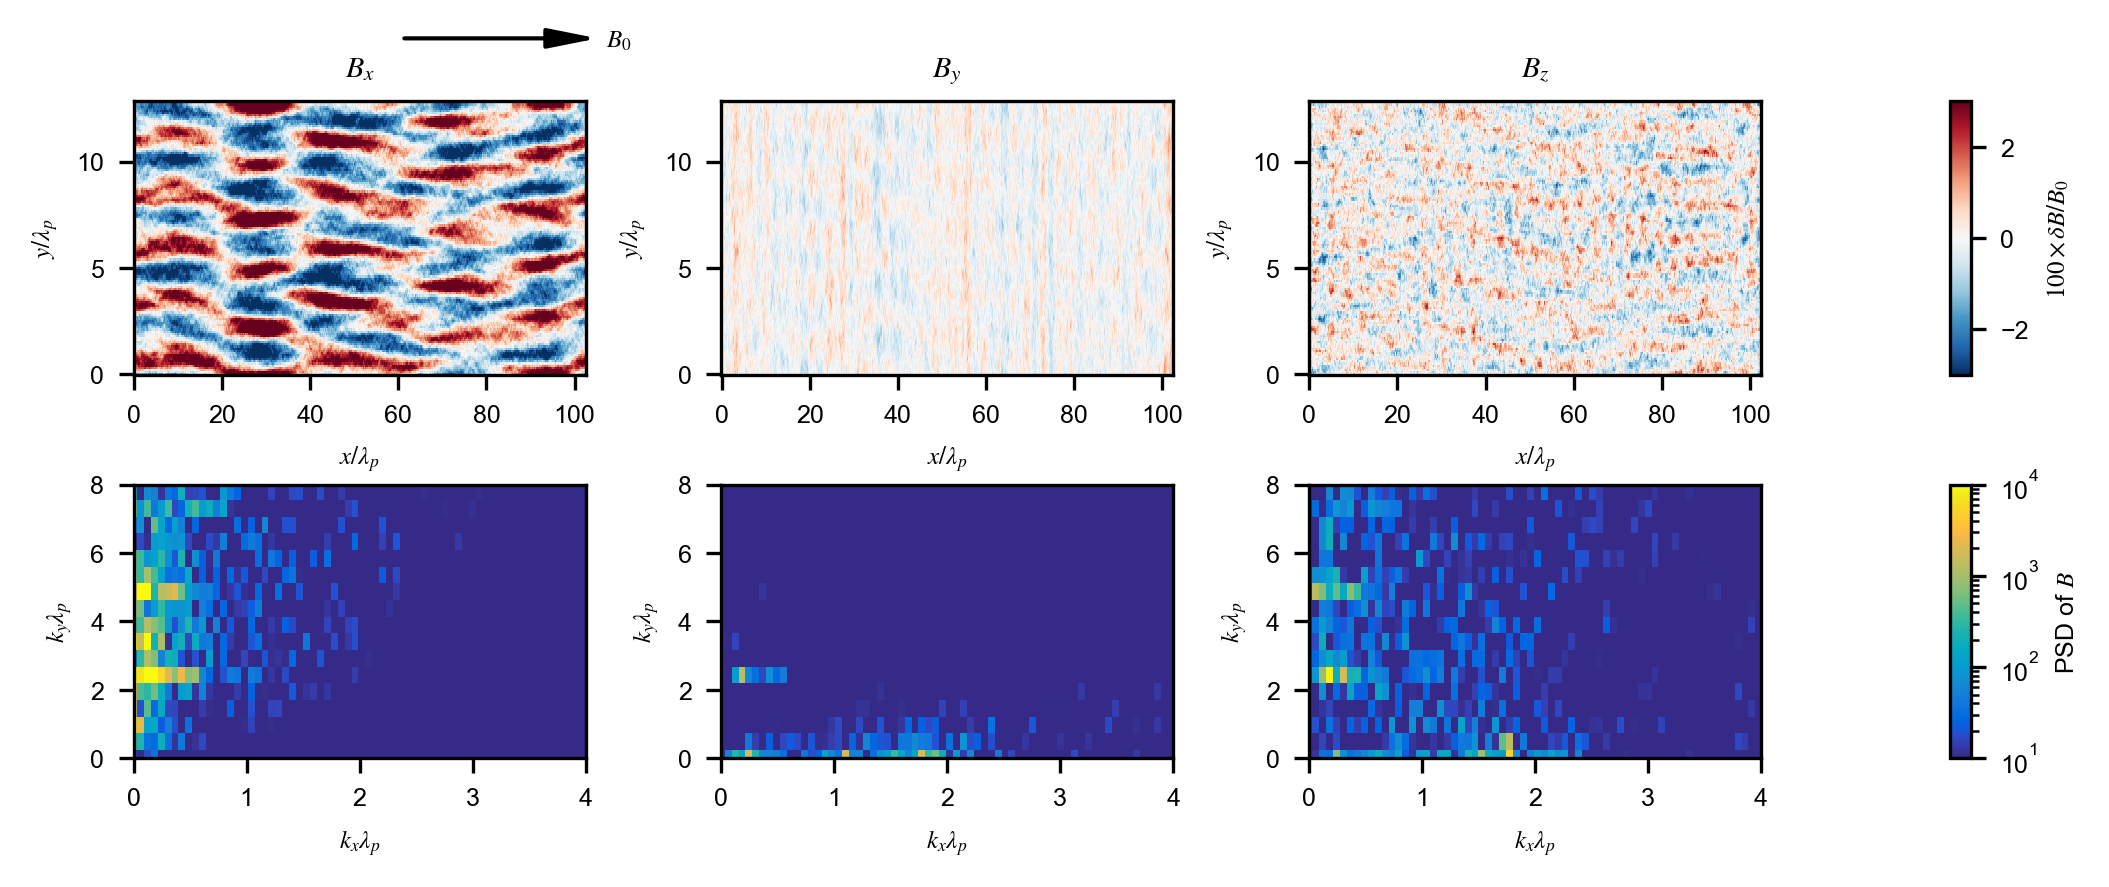

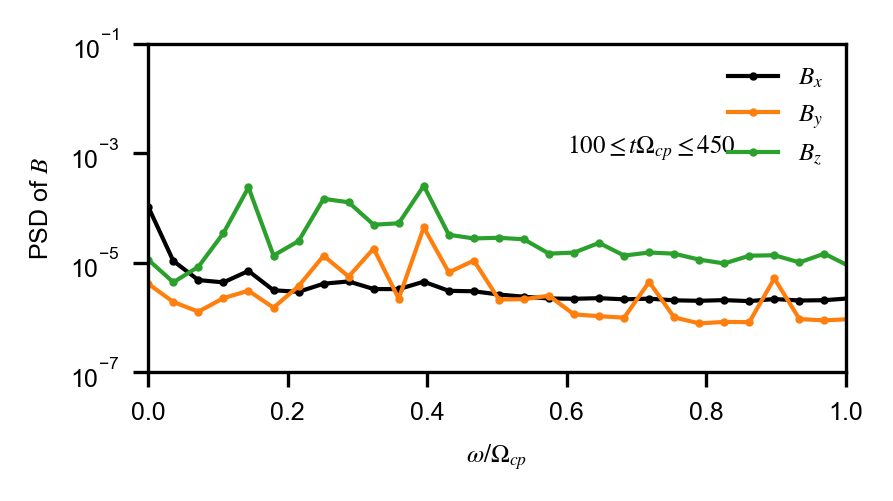

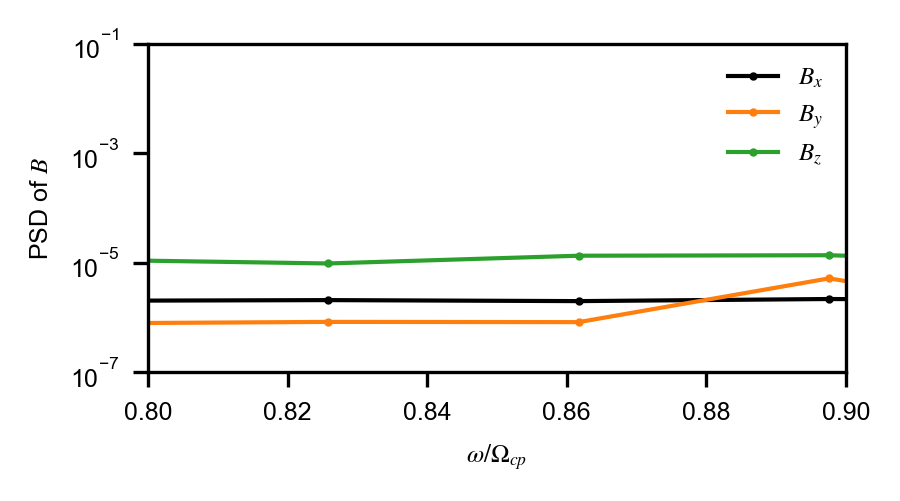

In [6]:
scale = 100
plt.close()
fig,axs = plt.subplots(2,3,figsize=[7, 3])
plt.subplots_adjust(wspace=0.3, hspace=0.4)  
# 箭头
# fig.suptitle("$t\Omega_{cp}=40$")
style = ArrowStyle('-|>', head_length=0.5, head_width=0.1)
arrow = FancyArrowPatch((0.25, 0.95), (0.35, 0.95),
                        arrowstyle=style,
                        clip_on=False,
                        mutation_scale=20,  # 控制箭头大小
                        color='black',
                        transform=fig.transFigure)  # 箭头颜色
# 将箭头添加到整个图上
fig.patches.append(arrow)
fig.text(0.35, 0.94,'$B_0$', color='black')

pcm0 = axs[0,0].pcolormesh(X*dx_norm, Y*dy_norm, scale*bx_space[:,:].T, cmap='RdBu_r', vmin=-3, vmax=3,rasterized=True)
pcm1 = axs[0,1].pcolormesh(X*dx_norm, Y*dy_norm, scale*by_space[:,:].T, cmap='RdBu_r', vmin=-3, vmax=3,rasterized=True)
pcm2 = axs[0,2].pcolormesh(X*dx_norm, Y*dy_norm, scale*bz_space[:,:].T, cmap='RdBu_r', vmin=-3, vmax=3,rasterized=True)
add_color_bar_V(pcm2, axs[0,2], fig, 
                width = 0.01,
                wspace = 0.09,
                label=r'$100 \times \delta B / B_0$', position='right')

axs[0,0].set_title('$B_x$')
axs[0,1].set_title('$B_y$')
axs[0,2].set_title('$B_z$')
for i in range(3):
    axs[0,i].set_xlabel('$x/\lambda_p$')
    axs[0,i].set_ylabel('$y/\lambda_p$')

pcm0 = axs[1,0].pcolormesh(kx, ky, xpsd_space, cmap=purula(), norm='log', vmin=1e1, vmax=1e4, rasterized=True)
pcm1 = axs[1,1].pcolormesh(kx, ky, ypsd_space, cmap=purula(), norm='log', vmin=1e1, vmax=1e4, rasterized=True)
pcm2 = axs[1,2].pcolormesh(kx, ky, zpsd_space, cmap=purula(), norm='log', vmin=1e1, vmax=1e4, rasterized=True)
add_color_bar_V(pcm2, axs[1,2], fig, 
                width = 0.01,
                wspace = 0.09,
                label=r'PSD of $B$', position='right')

for i in range(3):
    axs[1,i].set_xlim(0, (1/dx_norm)-1)
    axs[1,i].set_ylim(0, (1/dy_norm)-2)
    axs[1,i].set_xlabel('$k_x \lambda_p$')
    axs[1,i].set_ylabel('$k_y \lambda_p$')
# plt.tight_layout()
plt.show()

plt.close()
fig,ax = plt.subplots(figsize=[3, 1.5])
ax.set_yscale('log')
ax.plot(freq, xpsd, 'o-', c='black',  label='$B_x$', ms=1)
ax.plot(freq, ypsd, 'o-', c='C1',  label='$B_y$', ms=1)
ax.plot(freq, zpsd, 'o-', c='C2',  label='$B_z$', ms=1)
ax.set_xlim(0,1)
ax.set_ylim(1e-7, 1e-1)
ax.set_xlabel('$\omega/\Omega_{cp}$')
ax.set_ylabel('PSD of $B$')
ax.text(0.6,1e-3,'$100 \leq t\Omega_{cp} \leq 450$')
ax.legend()
plt.show()

plt.close()
fig,ax = plt.subplots(figsize=[3, 1.5])
ax.set_yscale('log')
ax.plot(freq, xpsd, 'o-', c='black',  label='$B_x$', ms=1)
ax.plot(freq, ypsd, 'o-', c='C1',  label='$B_y$', ms=1)
ax.plot(freq, zpsd, 'o-', c='C2',  label='$B_z$', ms=1)
ax.set_xlim(0.8,0.9)
ax.set_ylim(1e-7, 1e-1)
ax.set_xlabel('$\omega/\Omega_{cp}$')
ax.set_ylabel('PSD of $B$')
# ax.text(0.85,1e-3,'$100 \leq t\Omega_{cp} \leq 400$')
ax.legend()
plt.show()

In [7]:
fmin, fmax = 0.7, 1.0
mask = (freq >= fmin) & (freq <= fmax)
energy_freq = np.trapz(ypsd[mask]+zpsd[mask], freq[mask])
print(energy_freq)

ypsd_EMIC = ypsd[mask]
psd_max_idx = np.argmax(ypsd_EMIC)
f = freq[mask][psd_max_idx]
print(f)

3.619528439144608e-06
0.8975979010255786


In [8]:
#sample spacing
DT = t_select[1] - t_select[0]
fs = 1/DT  # ws = 2*pi*fs 采样频率
fc = 1.2/np.pi/2     # # 截止频率（低通）
w = fc/(fs/2)  # 归一化频率

b, a = butter(N=5, Wn=w, btype='low')  # 使用5阶巴特沃斯滤波器

# 滤波
filtered_By = np.zeros_like(By)
for i in range(By.shape[1]):
    for j in range(By.shape[2]):
        filtered_By[:,i,j] = filtfilt(b, a, By[:,i, j])

# 用积分和的形式计算滤波之后的能量
filtered_By_pow=np.zeros(len(By))
filtered_By_space=np.zeros((Nx+1,Ny+1))

for i in range(len(By)):
    filtered_By_pow[i]=np.sum(0.5 * np.power(filtered_By[i,:,:],2)*dx*dy) 

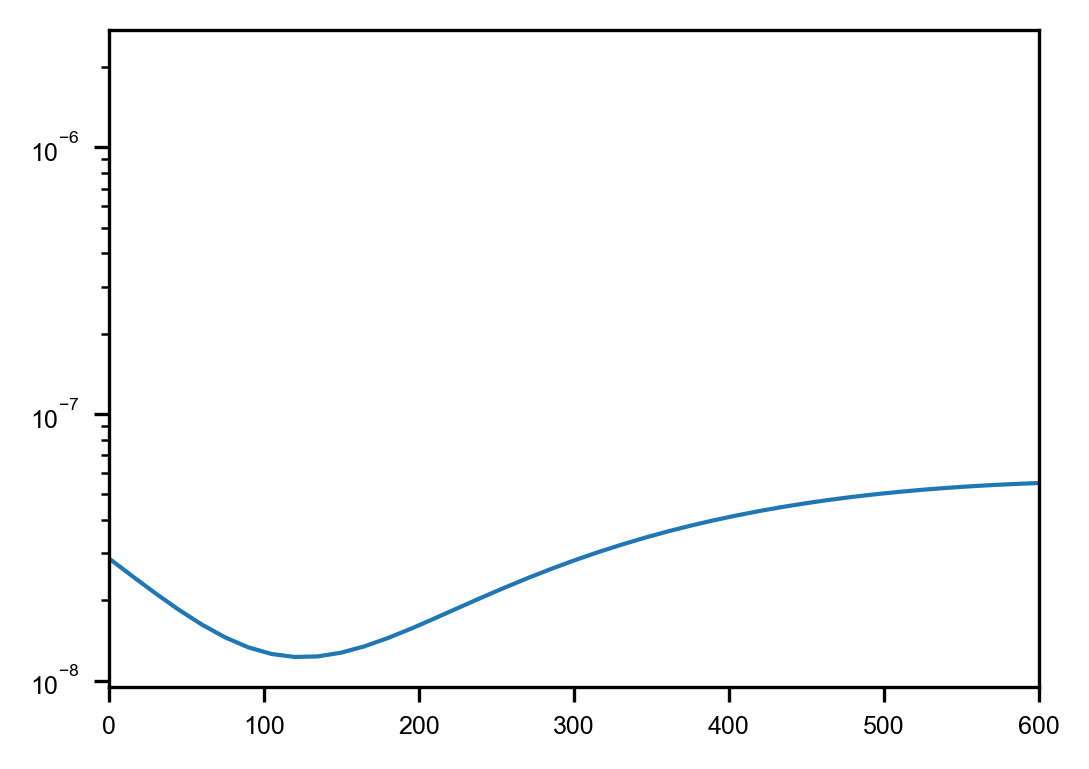

In [11]:
fig,ax = plt.subplots(figsize=[4,3])
ax.set_yscale('log')
ax.plot(field0_t[::2], filtered_By_pow/init_UB)
ax.set_xlim(0, 600)
plt.show()